In [1]:
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('default')

from qiskit.primitives import Sampler, BackendSampler
from qiskit import Aer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import CplexOptimizer

from os.path import dirname, abspath
import sys
parent_dir = dirname(dirname(abspath(' ')))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from src.optimizer.Quantum_Optimizer_FGSR_b import *
from src.encode.encode_onehot_eq import *
from src.bitflip_strategy.local_search_general import *

import warnings
warnings.simplefilter('ignore')

In [2]:
N = 65
id = 0

N_list = [10, 15, 20, 25, 35, 45, 50, 55, 65, 75, 100, 125]

In [3]:
fname = parent_dir + f'/instances/SSP/SSP_N{N}.npz'
Mat_data = np.load(fname)

np.random.seed(0)
c_obj = np.random.randint(0, 50, N)

A_const = Mat_data[f'data_{id}']

n_const = A_const.shape[0]
b_const = np.ones(n_const, dtype=int)

In [4]:
mdl = QuadraticProgram('Set Partitioning')

for k in range(N):
    mdl.binary_var(f'x({k})')

obj = mdl.minimize(linear=c_obj)

for k in range(n_const):
    mdl.linear_constraint(linear=A_const[k], sense='==', rhs=1)

In [5]:
qubo = QuadraticProgramToQubo().convert(mdl)

Q_info = qubo.objective.quadratic.coefficients.copy()
l_diag = qubo.objective.linear
for k in range(N):
    Q_info[k,k] += l_diag[k]
Q = Q_info.tocoo()
Q_data = np.stack([Q.row, Q.col, Q.data], axis=1)

offset = qubo.objective.constant

In [6]:
efficient_encode = create_encode()
efficient_encode.set_encode(c_obj, A_const)
decode = efficient_encode.decode

num_qubits = efficient_encode.n_qubits

print(f'number of system qubits: {num_qubits}')

number of system qubits: 19


In [7]:
def objective(x):
    x = decode(x)
    val = x @ Q @ x + offset
    return val

In [8]:
# max number of random flips for each bitstring
n_flips = 10

def search(x):
    x = local_search(x, func=objective, maxiter=n_flips)
    return x

In [9]:
n_reps = 3

q = QuantumRegister(num_qubits, name='q')
sub_qc = QuantumCircuit(q)
qc_params = ParameterVector(name='theta', length=num_qubits*n_reps)

for l in range(n_reps):
    k = 0
    while 2*k < num_qubits-1:
        sub_qc.cz(q[2*k], q[2*k+1])
        k += 1
            
    k = 0
    while 2*k+1 < num_qubits-1:
        sub_qc.cz(q[2*k+1], q[2*k+2])
        k += 1

    for k in range(num_qubits):
        sub_qc.ry(qc_params[l*num_qubits+k], q[k])

    sub_qc.barrier()

In [10]:
shots = 2**10
backend = Aer.get_backend('aer_simulator_matrix_product_state')

sampler = BackendSampler(backend=backend)
sampler.set_options(shots=shots)

print(f'shots = {shots}')

shots = 1024


In [11]:
cplex_result = CplexOptimizer().solve(mdl)
refval = cplex_result.fval

print(refval)

10.0


In [12]:
# configure
alpha = 0.4
max_epoch = 1
restart_s = 0.7
restart_std = 0

In [13]:
QuantumSolver = QuantumOptimizer()
QuantumSolver.set_optimizer(num_qubits, sub_qc, sampler)

QuantumSolver.run(
    objective = objective,
    search = search,
    alpha = alpha,
    random_update = True,
    max_epoch = max_epoch,
    restart_s = restart_s,
    restart_std = restart_std,
    refval = refval,
    intermediate_result_display = True
    )

epoch = 0 	 step = 0 	 objval = 53.000 	 cvar = 4396261.359   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = 28.000 	 cvar = 648283.234   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = 28.000 	 cvar = 1204420.659   	 s-prob = 0.000e+00
epoch = 0 	 step = 1 	 objval = 28.000 	 cvar = 1079509.090   	 s-prob = 0.000e+00
epoch = 0 	 step = 2 	 objval = 28.000 	 cvar = 1318015.039   	 s-prob = 0.000e+00
epoch = 0 	 step = 3 	 objval = 28.000 	 cvar = 1022732.590   	 s-prob = 0.000e+00
epoch = 0 	 step = 4 	 objval = 28.000 	 cvar = 670577.578   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = 25.000 	 cvar = 39.012   	 s-prob = 0.000e+00
epoch = 0 	 step = 1 	 objval = 25.000 	 cvar = 41.663   	 s-prob = 0.000e+00
epoch = 0 	 step = 2 	 objval = 25.000 	 cvar = 42.771   	 s-prob = 0.000e+00
epoch = 0 	 step = 3 	 objval = 25.000 	 cvar = 37.817   	 s-prob = 0.000e+00
epoch = 0 	 step = 4 	 objval = 25.000 	 cvar = 39.751   	 s-prob = 0.000e+00
epoch = 0 	 step = 5 	 objval =

In [14]:
result = QuantumSolver.elog

L1 = [3*i+1 for i in range(len(result))]
L2 = list(result)
L3 = list(QuantumSolver.plog)
L4 = list(QuantumSolver.log)

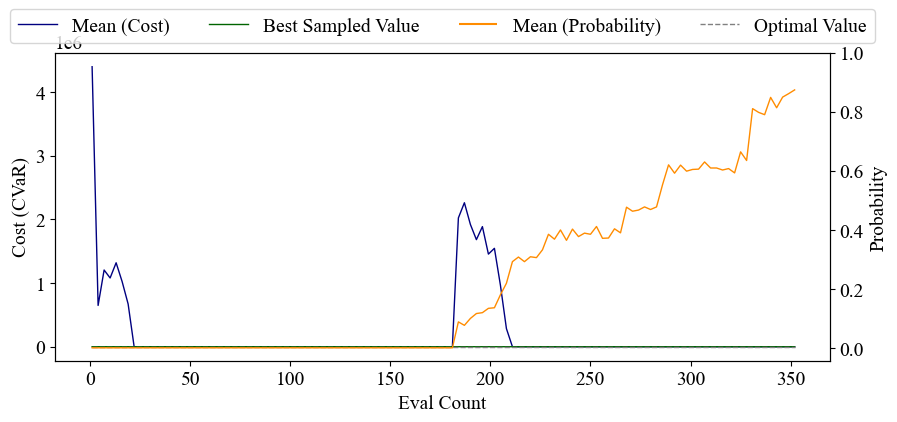

In [15]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.default'] = 'it'

fig, ax = plt.subplots(figsize=(10, 4))
ax2 = ax.twinx()

ax.plot(L1, L2, color='navy', linewidth=1, label='Mean (Cost)')
ax.plot(L1, L4, color='darkgreen', linewidth=1, label='Best Sampled Value')

ax.set_ylabel('Cost (CVaR)')
ax.set_xlabel('Eval Count')

ax.hlines(refval, xmin=0, xmax=0, color='darkorange', label='Mean (Probability)')
ax.hlines(refval, xmin=1, xmax=L1[-1], color='grey', linestyle='dashed', linewidth=1, label='Optimal Value')
ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)

ax2.plot(L1, L3, color='darkorange', linewidth=1)
ax2.set_ylabel('Probability')
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.show()